# Alex Bombrun 23/11/2017

A draft version of a python Gaia toy scanner

In [5]:
import numpy as np

In [6]:
%run frameRotation.py

In [7]:
%matplotlib inline

In [8]:
mp.rcParams['figure.figsize'] = [12.0, 8.0]

In [9]:
q=[0.5232034274305711, -0.24323625636196805, -0.5620956905735249, -0.5925729758895438] 
qPart=[0.5232034274305711, -0.24323625636196805, -0.5620956905735249, -0.5925729758895438]

In [10]:
def test0(q,qPart) :
    q0 = np.array(q)
    q1 = np.array(qPart)
    v = q1-q0
    return q0.dot(q0),q1.dot(q1),v.dot(v)

In [11]:
test0(q,qPart)

(0.9999999999999997, 0.9999999999999997, 0.0)

# Definitions and notations
* Satellite reference system : SRS (xyz)
* Baricentric reference system : BCRS (XYZ)
* Satellite position with respect to the baricenter : $b$
* time (in a first approximation we neglect all relativistic effect) : $t$
* Single source proper direction: $u = r+(t−t)(p \mu_{\alpha^*} + q \mu_{\delta} +r \mu_{r}) −  \varpi b(t)/A $


### Quaternion
* the quaternions $q$ are a corps in the $\text{R}^4$. Quaternions are used as a representation of a satellite attitude. 
* a vector $v \in \text{R}^3$ can be represented by a quaternion as $\{v,0\}$
* the rotation around unit vector $u$ with an angle $\phi$ is represented by the quaternion q:
    $$q = \{u \sin{\frac{\phi}{2}}, \cos{\frac{\phi}{2}} \}$$
* the image w of the vector v by this rotation is obtained as
    $$\{w,0\} = q^{-1} \{v,0\} q$$

## A purely geometric nominal attitude
Let v0 be a rotation around the X axis

In [12]:
def position(t) :
    """ simplified Gaia ephemerids in BCRS in AU
    t : time in year """
    phi = np.array(2 * np.pi * t)
    zeros = np.zeros(np.shape(phi))
    return np.array([np.cos(phi),np.sin(phi),zeros,zeros])

def qRotZ(t) :
    """rotation of position angle around Z BCRS axis"""
    phi = np.array(2 * np.pi * t)
    zeros = np.zeros(np.shape(phi))
    return np.array([zeros,zeros,np.sin(phi/2),np.cos(phi/2)])


def rotZ45() :
    """rotation of 45 degree around Z BCRS axis"""
    phi = np.pi/4 
    return np.array([0,0,np.sin(phi/2),np.cos(phi/2)])

def simpleP(t) :
    """ return simple precession 
    rotation around X axis in 63 days
    t : time in year """
    phi = 2*np.pi*365/63*np.array(t)
    zeros = np.zeros(np.shape(phi))
    return np.array([zeros, np.cos(phi),np.sin(phi),zeros])

def precession(t) :
    """
    return the precession direction
    t : time in year 
    """
    q = qRotZ(t)
    qInv = q_star(q)
    precession = q_mult(qInv,q_mult(simpleP(t),q))-position(t)
    return precession

def simpleSpinZ(t):
    """
    return simple spin direction
    rotation around X axis in 6 hours
    t : time in year """
    phi = 2*np.pi*365/0.25*np.array(t)
    zeros = np.zeros(np.shape(phi))
    return np.array([np.cos(phi),np.sin(phi),zeros,zeros])

def rotation(v1,v2): 
    x = v2;
    z = v1;
    zXx = np.cross(z,x)
    cosR = np.dot(z,x)
    sinR = np.linalg.norm(zXx)
    R = np.arctan2(sinR,cosR)
    zXx = np.sin(R/2) * zXx / np.linalg.norm(zXx)
    z2x = np.array([zXx[0],zXx[1],zXx[2],np.cos(R/2)])
    return z2x

Text(0.5,1,'spin versus precession')

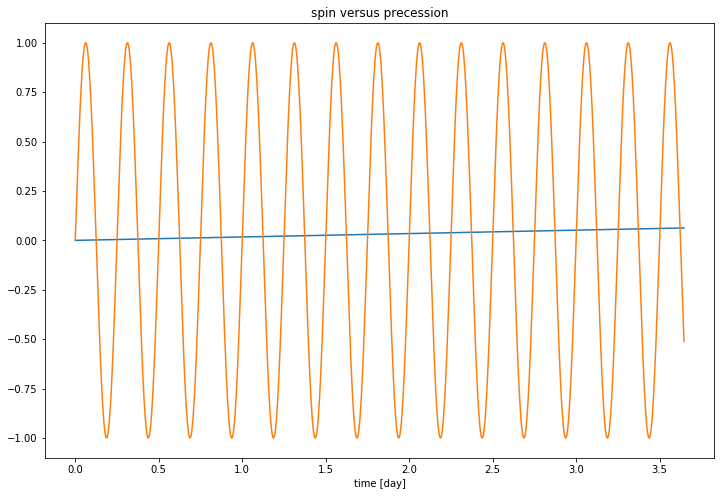

In [13]:
x = np.arange(0,0.01,0.00001)
plt.plot(x*(365),position(x)[1])
plt.plot(x*(365),simpleSpinZ(x)[1])
plt.xlabel("time [day]")
plt.title("spin versus precession")

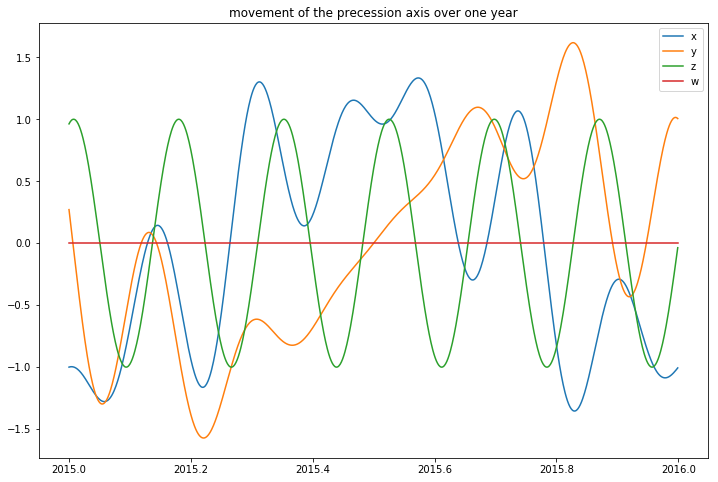

In [14]:
times = np.arange(2015,2016,0.001)
plt.plot(times,precession(times)[0],label="x")
plt.plot(times,precession(times)[1],label="y")
plt.plot(times,precession(times)[2],label="z")
plt.plot(times,precession(times)[3],label="w")
plt.title("movement of the precession axis over one year")
plt.legend()

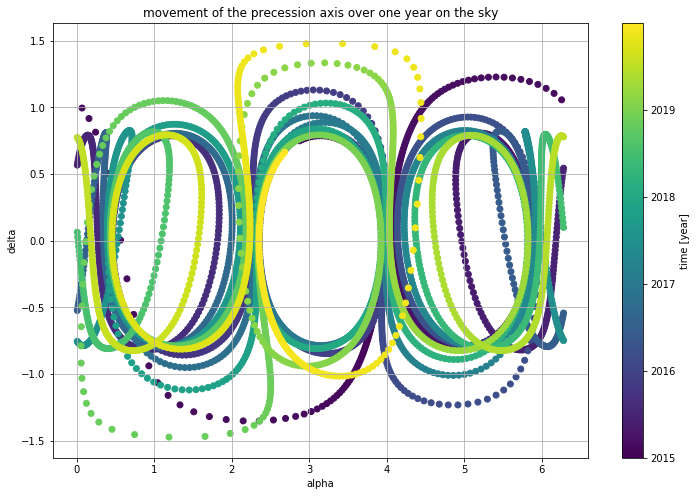

In [15]:
times = np.arange(2015,2020,0.001)
y = np.transpose(precession(times)[0:3])
norm_y = np.linalg.norm(y,axis=1) #not necessary
alphadelta = np.array([alphaDelta(ad/n) for ad,n in zip(y,norm_y)])
xy = np.transpose(alphadelta)
plt.scatter(xy[0],xy[1],c=times)
plt.colorbar(label="time [year]")
plt.xlabel("alpha")
plt.ylabel("delta")
plt.title("movement of the precession axis over one year on the sky")
plt.grid()

In [16]:
def nsl_x(t) :
    """ Gaia SRS x axis in BCRS"""
    Z = np.array([0,0,1])
    z = precession(t)
    v = simpleSpinZ(t)
    q = rotation(Z,z[0:3])
    
    v = np.array([v[0],v[1],v[2],0])
    q_inv = q_star(q)
    return q_mult(q,q_mult(v,q_inv))

# TODO define preceding and following direction

In [17]:
nsl_x(0)

(0.5000000000000001, 0.4999999999999999, 0.4571067811865475, 0.25)

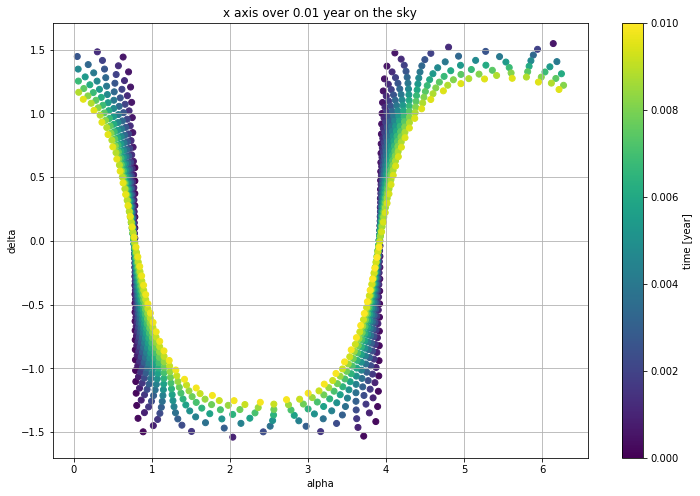

In [18]:
times = np.linspace(0,0.01,1000)
y = np.array([nsl_x(t)[0:3] for t in times])
norm_y = np.linalg.norm(y,axis=1)
alphadelta = np.array([alphaDelta(ad/n) for ad,n in zip(y,norm_y)])
xy = np.transpose(alphadelta)
plt.scatter(xy[0],xy[1],c=times)
plt.colorbar(label="time [year]")
plt.xlabel("alpha")
plt.ylabel("delta")
plt.title("x axis over 0.01 year on the sky")
plt.grid()

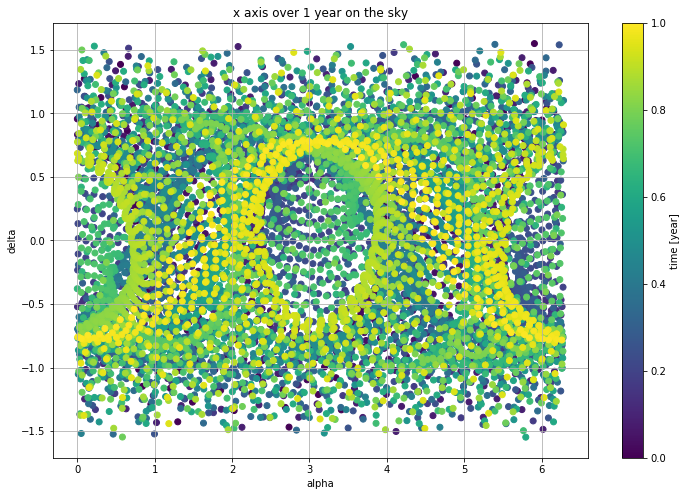

In [19]:
times = np.linspace(0,1,10000)
y = np.array([nsl_x(t)[0:3] for t in times])
norm_y = np.linalg.norm(y,axis=1)
alphadelta = np.array([alphaDelta(ad/n) for ad,n in zip(y,norm_y)])
xy = np.transpose(alphadelta)
plt.scatter(xy[0],xy[1],c=times)
plt.colorbar(label="time [year]")
plt.xlabel("alpha")
plt.ylabel("delta")
plt.title("x axis over 1 year on the sky")
plt.grid()

# Single source model

In [20]:
def sourceDirection(alpha,delta,varpi,muAlphaStar,muDelta,t):
    """
    computes and return the source direction at time t
    unit in radian or radian per year
    time in year
    """
    tRef=2015
    p,q,r = pqr(alpha,delta)
    b = position(t)[:3]
    u = r + (t-tRef)*(muAlphaStar * p + muDelta * q) -  varpi * b
    return u

In [21]:
import astropy.units as u

In [22]:
alpha=0.1625
delta=0.16
varpi= 1 * u.mas.to(u.rad)
mu_alpha_star =  1 * u.mas.to(u.rad)
mu_delta =  1 * u.mas.to(u.rad)

In [23]:
s = lambda t : alphaDelta(sourceDirection(alpha,delta,varpi,mu_alpha_star,mu_delta,t))

In [24]:
s(2016)

(0.1625000057053695, 0.16000000561035768)

Note this code is not numpy complient

Text(0,0.5,'delta [mas]')

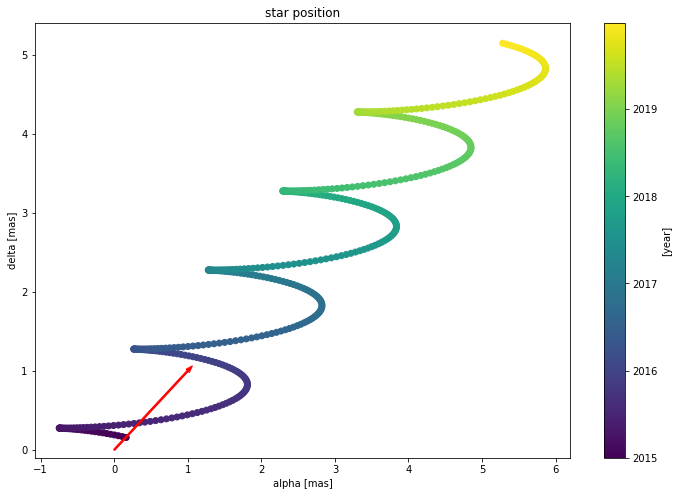

In [25]:
scale = varpi
times = np.arange(2015,2020,0.01)
x = np.array([s(t) for t in times])
plt.scatter((x[:,0]-alpha)/scale,(x[:,1]-delta)/scale,c=times)
plt.colorbar(label="[year]")
plt.arrow(0,0,mu_alpha_star/scale,mu_delta/scale,color='r',width=0.02)
plt.title("star position")
plt.xlabel("alpha [mas]")
plt.ylabel("delta [mas]")

In [27]:
u.milliarcsecond.to(u.radian)

4.84813681109536e-09

# TODO given the x direction and a star find the transit times : 
the times the star is alligned with the x direction with a given margin error in tha AC direction of +- 0.35 degree.

One can start with the x direction, one can restrict the search interval to the periods where z is ortogonal to the stars, i.e. the starts is within some great cicle annulus define by z. 

The example below was done with a manual search

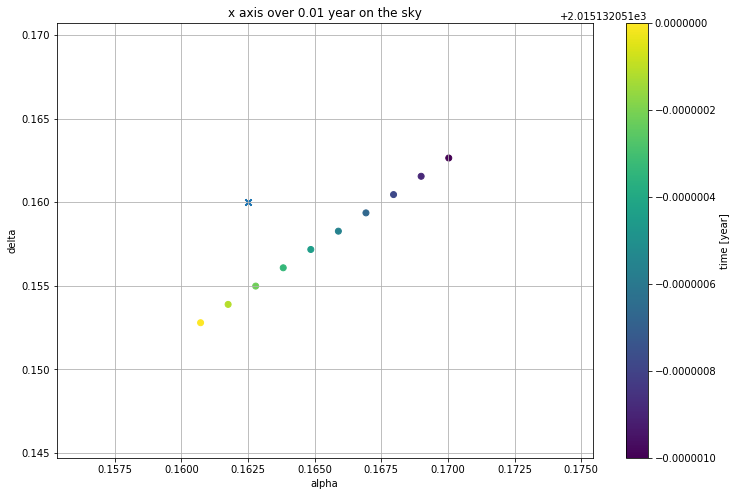

In [28]:
#attitude
times = np.linspace(2015.13205,2015.132051,10)
y = np.array([nsl_x(t)[0:3] for t in times])
norm_y = np.linalg.norm(y,axis=1)
alphadelta = np.array([alphaDelta(ad/n) for ad,n in zip(y,norm_y)])
xy = np.transpose(alphadelta)
plt.scatter(xy[0],xy[1],c=times)
plt.colorbar(label="time [year]")
plt.xlabel("alpha")
plt.ylabel("delta")
plt.title("x axis over 0.01 year on the sky")
plt.grid()
#source
x = np.array([s(t) for t in times])
plt.scatter(x[:,0],x[:,1],marker='x')

In [317]:
u.degree.to(u.radian)

0.017453292519943295